# Insect Recognizer

## Introduction

This notebook is the starting point for insect recognizer.

## Data Fetching

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
new_dir = "../datasets/initialTestDataSetV2/cleaned"

train_datagen = ImageDataGenerator(
    rescale=1./255,       # normalize pixel values
    rotation_range=20,    # small random rotation
    zoom_range=0.2,       # small random zoom
    horizontal_flip=True  # flip image horizontally
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    new_dir,
    target_size=(224,224),   # resize all images
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

Found 4873 images belonging to 23 classes.


## Data Understanding

### Classes

In [3]:
# Check the class labels detected by the generator
print("Class indices:", train_generator.class_indices)

# Reverse dictionary (to map index -> class name)
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

Class indices: {'ant': 0, 'bee': 1, 'bee_apis': 2, 'bee_bombus': 3, 'beetle': 4, 'beetle_ladybug': 5, 'beetle_oedem': 6, 'butterfly': 7, 'dragonfly': 8, 'fly': 9, 'fly_empi': 10, 'fly_hoverfly_episyr': 11, 'fly_hoverfly_eristal': 12, 'fly_hoverfly_eupeo': 13, 'fly_hoverfly_myathr': 14, 'fly_hoverfly_sphaero': 15, 'fly_hoverfly_syrphus': 16, 'fly_mosquito': 17, 'fly_sarco': 18, 'fly_small': 19, 'grasshopper': 20, 'mecoptera_scorpionfly': 21, 'wasp': 22}
Class labels: ['ant', 'bee', 'bee_apis', 'bee_bombus', 'beetle', 'beetle_ladybug', 'beetle_oedem', 'butterfly', 'dragonfly', 'fly', 'fly_empi', 'fly_hoverfly_episyr', 'fly_hoverfly_eristal', 'fly_hoverfly_eupeo', 'fly_hoverfly_myathr', 'fly_hoverfly_sphaero', 'fly_hoverfly_syrphus', 'fly_mosquito', 'fly_sarco', 'fly_small', 'grasshopper', 'mecoptera_scorpionfly', 'wasp']


### Number of Images

In [4]:
print("Number of training samples:", train_generator.samples)
# print("Number of validation samples:", val_generator.samples)

Number of training samples: 4873


### Some Images

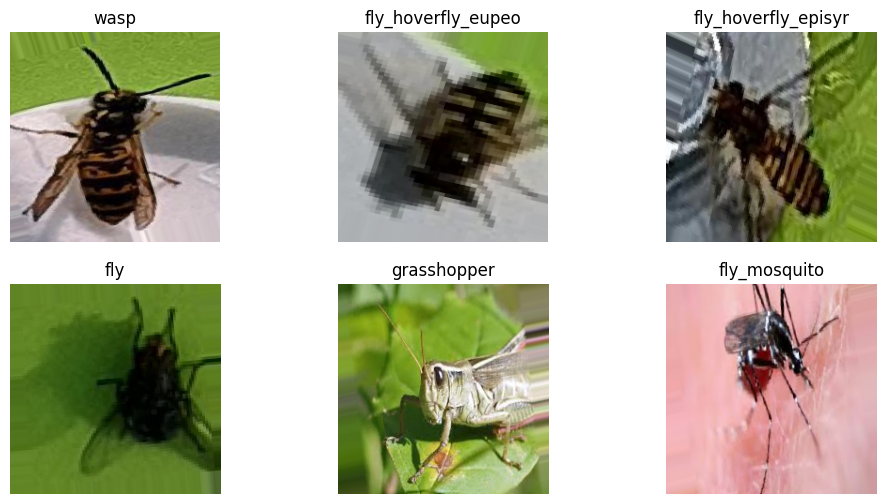

In [5]:
# Get one batch of images and labels
images, labels = next(train_generator)

# Show first 6 images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].argmax()])  # get class name
    plt.axis("off")
plt.show()

### Class Distribution

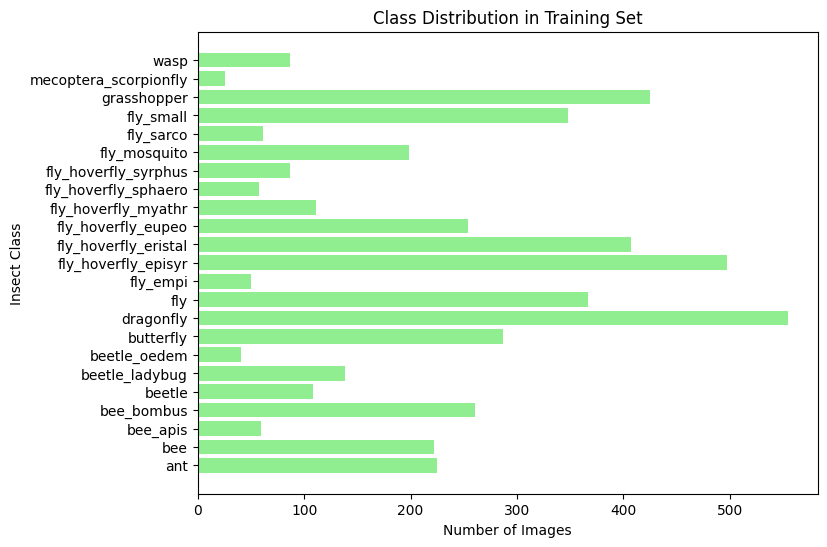

In [6]:
# Count number of samples for each class in training set
train_counts = np.bincount(train_generator.classes)

# Plot horizontal bar chart
plt.figure(figsize=(8,6))   # bigger figure
plt.barh(class_labels, train_counts, color="lightgreen")
plt.xlabel("Number of Images")
plt.ylabel("Insect Class")
plt.title("Class Distribution in Training Set")
plt.show()

## Data Preparation

### Fixing Class Imbalance

In [8]:
# This value generated by the weight distribution class that need to be taken into account when training the model or to prevent biases.

# Convert to numpy array for easy masking
train_counts = np.array(train_counts)
class_labels = np.array(class_labels)

# Exclude classes with too few samples
exclude_classes = ["beetle_oedem", "mecoptera_scorpionfly"]
mask = ~np.isin(class_labels, exclude_classes)

filtered_labels = class_labels[mask]
filtered_counts = train_counts[mask]

# Target number of images per class
target_images = 50

# Calculate class weights so that each class is scaled to 50
# Example: if a class has 200 images, weight = 50 / 200 = 0.25
class_weights = target_images / filtered_counts
class_weights = np.round(class_weights, 3)  # Rounded for readability

# Show calculated weights
for label, weight in zip(filtered_labels, class_weights):
    print(f"{label}: {weight}")

ant: 0.222
bee: 0.225
bee_apis: 0.847
bee_bombus: 0.192
beetle: 0.463
beetle_ladybug: 0.362
butterfly: 0.174
dragonfly: 0.09
fly: 0.136
fly_empi: 1.0
fly_hoverfly_episyr: 0.101
fly_hoverfly_eristal: 0.123
fly_hoverfly_eupeo: 0.197
fly_hoverfly_myathr: 0.45
fly_hoverfly_sphaero: 0.862
fly_hoverfly_syrphus: 0.575
fly_mosquito: 0.251
fly_sarco: 0.82
fly_small: 0.144
grasshopper: 0.118
wasp: 0.575


### Visualize adjusted "equalized" distribution

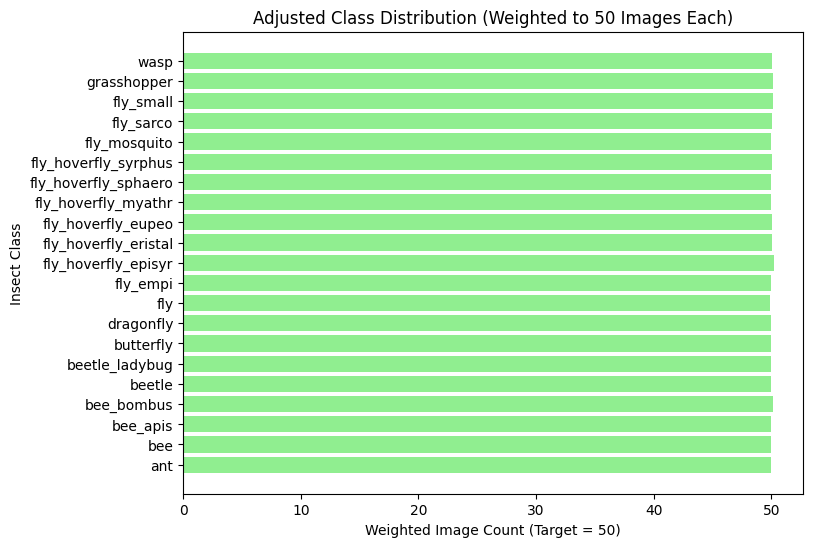

In [10]:
plt.figure(figsize=(8,6))
plt.barh(filtered_labels, filtered_counts * class_weights, color="lightgreen")
plt.xlabel("Weighted Image Count (Target = 50)")
plt.ylabel("Insect Class")
plt.title("Adjusted Class Distribution (Weighted to 50 Images Each)")
plt.show()